In [1]:
from __future__ import division
import fnmatch
import numpy as np
import os
import read_mp3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# http://stackoverflow.com/questions/2186525/use-a-glob-to-find-files-recursively-in-python
# Here's the Python 3.4 way...
matches = []
for root, dirnames, filenames in os.walk('music'):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        matches.append(os.path.join(root, filename))

In [153]:
audio, sample_rate = [], []

for match in matches[:4]:
    a, m = read_mp3.ffmpeg_load_audio(match)
    audio.append(a)
    sample_rate.append(m)

In [157]:
sample_rate

[44100, 44100, 44100, 44100]

In [161]:
audio[0].shape

(2, 8673408)

In [10]:
print(audio.max(), audio.min())

0.933073 -0.939299


In [59]:
X = audio.reshape((1, 1, 2, -1))

In [60]:
X = X[:,:,:,:4096]

In [61]:
X.shape

(1, 1, 2, 4096)

In [168]:
def pad_tune(tune, sample_length=2**16):
    """Zero pad a 2 channel audio and reshape into rank 4 tensor
    
    Example, sample_length=65536:
    (2, 8673408) -> (133, 1, 2, 65536)
    """
    n_samples = tune.shape[1]//sample_length + 1
    pad_length = sample_length*n_samples - tune.shape[1]
    T = np.pad(tune, ((0,0),(0,pad_length)), 'constant')
    
    return T.reshape(-1, 1, 2, 2**16)

In [171]:
TT = []
for tune in audio:
    TT.append(pad_tune(tune))

In [174]:
X = np.vstack(TT)

In [175]:
X.shape

(474, 1, 2, 65536)

In [128]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(1, 2, 2**16))

x = Convolution2D(16, 2, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 1, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((1, 2), border_mode='same')(x)
x = Convolution2D(8, 1, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((1, 2), border_mode='same')(x)


x = Convolution2D(8, 1, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((1, 2))(x)
x = Convolution2D(8, 1, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((1, 2))(x)
x = Convolution2D(16, 1, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(2, 2, 3, activation='tanh', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mse')

In [180]:
from keras.callbacks import TensorBoard

history = autoencoder.fit(X, X, 
                          nb_epoch=5,
                          batch_size=10,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=1)])

Train on 379 samples, validate on 95 samples
Epoch 1/5
379/379 [==============================] - 247s - loss: 0.0528 - val_loss: 0.0669
Epoch 2/5
379/379 [==============================] - 252s - loss: 0.0525 - val_loss: 0.0664
Epoch 3/5
379/379 [==============================] - 256s - loss: 0.0521 - val_loss: 0.0659
Epoch 4/5
379/379 [==============================] - 254s - loss: 0.0517 - val_loss: 0.0653
Epoch 5/5
379/379 [==============================] - 253s - loss: 0.0512 - val_loss: 0.0646


In [177]:
autoencoder.fit?

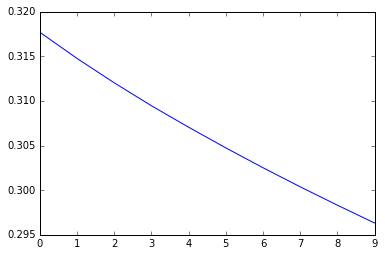

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.show()

In [71]:
import numpy as np

In [114]:
T = audio[:]

In [115]:
T.shape

(2, 8673408)

In [119]:
T = np.pad(T, ((0,0),(0,42880)), 'constant')

In [120]:
T.shape

(2, 8716288)

In [121]:
133*2**16 - T.shape[-1]

0

In [123]:
T = T.reshape(-1, 1, 2, 2**16)

In [124]:
T.shape

(133, 1, 2, 65536)

In [91]:
a = a.reshape((2, 3))

In [131]:
T.shape

(133, 1, 2, 65536)

In [111]:
np.pad(a, ((0,0),(0,2)), 'constant')

array([[0, 1, 2, 0, 0],
       [3, 4, 5, 0, 0]])

In [130]:
from IPython.display import Audio

In [134]:
sample = T[1,0,:,:]

In [135]:
sample.shape

(2, 65536)

In [136]:
type(sample)

numpy.ndarray

In [137]:
Audio(sample, rate=44000)

In [138]:
Y = autoencoder.predict(T)

In [139]:
new_sample = Y[1,0,:,:]

In [140]:
Audio(new_sample, rate=44000)